In [1]:
import torch.nn as nn
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
torch.autograd.set_detect_anomaly(True)
import websocket, json, pprint, talib, numpy
import websockets
from binance.client import Client
from binance.enums import *
import joblib
import robin_stocks as rs
import config
import asyncio
import nest_asyncio
import time

In [2]:
rs.robinhood.login(username= config.RH_USER, password= config.RH_PASS, expiresIn=86400, by_sms=True)

{'access_token': 'eyJ0eXAiOiJKV1QiLCJhbGciOiJSUzI1NiJ9.eyJleHAiOjE2NTI4MjQ0MTIsInRva2VuIjoiSVZVMXluUXBHa28xa3dRT3J3ZlVmenFQcHp0NloyIiwidXNlcl9pZCI6Ijk1MmFhMzljLTBhMjQtNDliMS05MjQ0LWE2NmM0ZTYzZDQzOCIsImRldmljZV9oYXNoIjoiNzZkMTM3YmU4YzExYTY1OTA4YjViNDIyOTkyMmYzZGIiLCJzY29wZSI6ImludGVybmFsIiwiZGN0IjoxNjUyMTIxMTM2LCJzZXJ2aWNlX3JlY29yZHMiOlt7ImhhbHRlZCI6ZmFsc2UsInNlcnZpY2UiOiJudW1tdXNfdXMiLCJzaGFyZF9pZCI6MSwic3RhdGUiOiJhdmFpbGFibGUifSx7ImhhbHRlZCI6ZmFsc2UsInNlcnZpY2UiOiJicm9rZWJhY2tfdXMiLCJzaGFyZF9pZCI6Niwic3RhdGUiOiJhdmFpbGFibGUifV0sInVzZXJfb3JpZ2luIjoiVVMiLCJvcHRpb25zIjp0cnVlLCJsZXZlbDJfYWNjZXNzIjpmYWxzZX0.KuT4wFtndQo_p50zmGwAxFQ4er6pK1jmrf1IAzG_oMW_dxF9WyWr2JINOVafB5GzDL0C1R-YDnhV3jiHcdcByG5agKIrk-rsIryczLUSvnWQUxHKVI6Cs5m9ZFGNCvFnyHkbKGIbGvh63Q_TqT-Hvb2i23dSjJ-B8fDzjzDhpInJmxTriAVVCxroJ1xygbVNDg9vODBSctX9NwaF2UpAhdEyAbG4_KrMgRkzVhM3DG1ZicZVgSrRJqpVPmdVwYdhSw2JBOOresWAZZXfXgTYV6eCz91m2kffWgIimgKmxh_t6XWc_jOPEQMORKWGzaL_6dAGa2kU-o_RoULPJlFfKw',
 'token_type': 'Bearer',
 'expires_in': 8640

In [3]:
#rs.robinhood.order_buy_crypto_by_price('ETH', 1)

In [4]:
data = pd.read_csv('data_15m.csv')
data = data.iloc[:25201]
#labels = data.loc[:, "labels"]
close = data.loc[:, "closes"]
close = close.iloc[1:]
data = data.iloc[:-1]
data = data.drop(["labels"], axis=1)
data.head()

print(len(data), len(close))

25200 25200


In [5]:
data = data.to_numpy()
close = close.to_numpy()
#extra = np.shape(data)[0] % 32
#data = data[extra:, :]
data = torch.tensor(data)
data = data.to(torch.float)
#close = close[extra:]
close = torch.tensor(close)
close = close.to(torch.float)
data, X_test, close, y_test = train_test_split(data, close, test_size=0.5, shuffle = False)
print(len(data), len(X_test), len(close), len(y_test))
class Dataset():
    def __init__(self, array, labels):
        self.array = array
        self.labels = labels

    def __len__(self):
        return self.array.shape[0]

    def __getitem__(self, idx):
        return self.array[idx, :], self.labels[idx]


12600 12600 12600 12600


In [6]:
batch_size = 1 
fulldata = Dataset(data, close)
dataloader = DataLoader(fulldata, batch_size)
loss_function = nn.MSELoss()

testdata = Dataset(X_test, y_test)
testdataloader = DataLoader(testdata, batch_size)

pred_array = np.zeros(len(data))

In [7]:
class RNNModel(torch.nn.Module):
    def __init__(self, input_size, HL_size, num_layers = 1):
        super(RNNModel, self).__init__()
        self.rnn = torch.nn.RNN(input_size=input_size,
                                hidden_size=HL_size,
                                num_layers=num_layers)
        
        self.linear = torch.nn.Linear(HL_size , 12)
        self.linear2 = torch.nn.Linear(12, 1)
        self.num_layers = num_layers
        self.hidden_size = HL_size
        
    def forward(self, inputs, hidden):
        out, hidden = self.rnn(inputs, hidden)
        pred = self.linear(out)
        pred = self.linear2(pred)

        #hidden = hidden.view(-1, 1, self.hidden_size)
        return pred, hidden
    
    def init_hidden(self, batch = 1):
        hidden = torch.randn(self.num_layers, batch, self.hidden_size)
        return hidden

def rnn_train():
    model = RNNModel(np.shape(data)[1], HL_size = 24, num_layers = 1)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    hidden = model.init_hidden(batch_size)
    total_loss = 0
    for batch_idx, (batch, truth) in enumerate(dataloader):
        
        hidden = hidden.detach()

        batch = np.reshape(batch, (1, -1, 11))
        pred, hidden = model.forward(batch, hidden)

        pred = torch.squeeze(pred, 0)
        pred = torch.squeeze(pred, 1)
        #print(pred)
        pred_array[batch_idx] = pred.item()
        single_loss = loss_function(pred, truth)
        single_loss.backward(retain_graph=True)
        clip_grad_norm_(model.parameters(), 5)
        optimizer.step()
        optimizer.zero_grad()
        total_loss = total_loss + single_loss.item()
        if batch_idx % 100 == 0:
            print(batch_idx)
            print(total_loss)
            #print(hidden)
            total_loss = 0
            
    '''
    for name, param in model.named_parameters():
                if param.requires_grad:
                    print(name, param.data)
    '''
    return model, hidden
            
trained_model, final_hidden = rnn_train()

0
0.5209998488426208
100
5.290888562289624
200
1.2510871219043302
300
1.4045983011985186
400
0.3561068062178663
500
2.402070299375339
600
0.666559114081025
700
0.6433038921155827
800
0.4868638142291388
900
0.33207011054685154
1000
0.3077010319289002
1100
0.21388352220503748
1200
0.29876755558376544
1300
0.26754006626788396
1400
0.28791058468573283
1500
1.1038928209222831
1600
0.49622792228724677
1700
0.451707058638533
1800
0.18393019335604777
1900
0.1445896613986406
2000
0.6255595822700712
2100
0.6823691676449357
2200
0.5651129095695921
2300
0.690681711559364
2400
0.4384825184033616
2500
0.7102925840317766
2600
0.5046347478146913
2700
0.42028090987378164
2800
0.2285455826283851
2900
0.1338572872500663
3000
1.3185248245026742
3100
0.2789602972169547
3200
0.4194034316296893
3300
0.29831396180497904
3400
0.7057196934071044
3500
0.994061372487522
3600
0.34792826097238105
3700
0.27473376736384125
3800
0.38879197899133544
3900
1.4185942449193796
4000
0.4842174974936171
4100
1.007488331351524

12600
12600
[-0.31161673 -0.31161673 -0.31161673 ... -1.42130582 -1.39607172
 -1.41063413]
tensor([-0.3116, -0.3116, -0.3116,  ..., -1.3961, -1.4106, -1.4216])


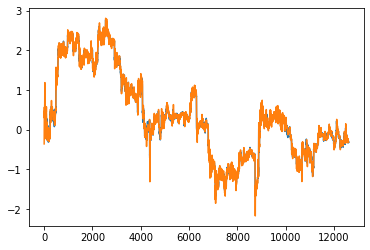

In [8]:
data2 = pd.read_csv('data_15m.csv')
data2 = data2.iloc[12600: 25200]
truth_array = data2.loc[:, "closes"].to_numpy()
close_numpy = close.numpy()
print(len(truth_array))
print(len(pred_array))
print(truth_array)
print(y_test)
plt.plot(close_numpy)
plt.plot(pred_array)
plt.show()

In [9]:
hidden = final_hidden
total_batches = 0
total_error = 0

#model = RNNModel(np.shape(data)[1], HL_size = 24, num_layers = 2)

optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.01)
    
for batch_idx, (batch, truth) in enumerate(testdataloader):
    optimizer.zero_grad()
    hidden = hidden.detach()
    batch = np.reshape(batch, (1, -1, 11))
    pred, hidden = trained_model.forward(batch, hidden)
    pred = torch.squeeze(pred, 0)
    pred = torch.squeeze(pred, 1)
    single_loss = loss_function(pred, truth)
    single_loss.backward(retain_graph=True)
    clip_grad_norm_(trained_model.parameters(), 5)
    optimizer.step()
    total_batches += 1
    if (pred < truth_array[batch_idx] and truth > truth_array[batch_idx]) or \
        (pred > truth_array[batch_idx] and truth < truth_array[batch_idx]):
            total_error +=1
    if batch_idx % 100 == 0:
            print(batch_idx)
                                                                 

        
print('######\n', total_error)
print(total_batches)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
######
 3903
12600


## Live Prediction

In [10]:
SOCKET = "wss://stream.binance.com:9443/ws/ethusdt@kline_15m"

RSI_PERIOD = 14
TRADE_SYMBOL = 'ETHUSD'

client = Client(config.KEY, config.SECRET, tld='us')

scaler = joblib.load('standard_scaler_15m.save')

In [11]:
# import time
# currMilli = round(time.time() * 1000)
# currCandles = client.get_klines(symbol='ETHUSDT', 
#                                 interval=Client.KLINE_INTERVAL_1MINUTE, 
#                                 startTime = (currMilli - 900000), 
#                                 endTime = (currMilli),
#                                 limit = 14)

# #print(currCandles)


# opens = [float(c[1]) for c in currCandles]
# closes = [float(c[4]) for c in currCandles]
# volumes = [float(c[5]) for c in currCandles]
# highs = [float(c[2]) for c in currCandles]
# lows = [float(c[3]) for c in currCandles]
# qavs = [float(c[7]) for c in currCandles]
# numTrades = [float(c[8]) for c in currCandles]
# tbbavs = [float(c[9]) for c in currCandles]
# tbqavs = [float(c[10]) for c in currCandles]

# closes.reverse()
# volumes.reverse()

# rsis = []
# obvs = []
# scaled_df = None
# hidden_squeeze = torch.squeeze(hidden, 1)
# df_history = pd.DataFrame(data={"time": [], "opens": [], "highs": [], "lows": [], "closes": [], "volumes": [], "qavs": [], "numTrades": [], "tbbavs": [], "tbqavs": [], "rsis": [],"obvs": []})
# count = 0
# correct = 0
# boughtPrev = False
# closePrev = float(0)
# predPrev = float(0)
# money = float(0)


# async def on_message():
#     global hidden_squeeze, closePrev, boughtPrev, closes, in_position, opens, highs, lows, volumes, qavs, numTrades, tbbavs, tbqavs, rsis, obvs, df_history, money, count, correct
    
    
#     #print('CLOSES: ', len(closes), closes)
#     #print('received message')
#     json_message = json.loads(message)
#     #pprint.pprint(json_message)

#     candle = json_message['k']
 
#     is_candle_closed = candle['x']
#     close = float(candle['c'])
#     open_ = float(candle['o'])
#     high = float(candle['h'])
#     low = float(candle['l'])
#     vol = float(candle['v'])
#     qav = float(candle['q'])
#     numTrade = float(candle['n'])
#     tbbav = float(candle['V'])
#     tbqav = float(candle['Q'])
#     time = candle['t']

#     if is_candle_closed:
#         print("candle closed at {}".format(close))
#         closes.insert(0, close)
#         volumes.insert(0, vol)
#         opens.append(float(open_))
#         highs.append(float(high))
#         lows.append(float(low))
#         qavs.append(float(qav))
#         numTrades.append(float(numTrade))
#         tbbavs.append(float(tbbav))
#         tbqavs.append(float(tbqav))
        
# #         if(predPrev != float(0)):
# #             df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [1],"obvs": [1]})
# #             scaled_df = scaler.transform(df)
# #             scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
# #             data = scaled_df.to_numpy()
# #             truePred = data[0][3]
# #             print("\nBack Propogate... \n")
                                  
# #             predPrev =  torch.squeeze(predPrev, 1)
# #             predPrev =  torch.squeeze(predPrev, 0)
# #             truePred = torch.tensor(truePred)
# #             truePred = truePred.to(torch.float)
            
# #             print(predPrev, np.shape(predPrev), truePred, np.shape(truePred))

# #             single_loss = loss_function(predPrev, truePred)
# #             print('1')
# #             single_loss.backward()
# #             print('2')
# #             clip_grad_norm_(trained_model.parameters(), 5)
# #             print('3')
# #             optimizer.step()
# #             print('4')
# #             optimizer.zero_grad()
        
#         if(boughtPrev):
#             print('here\n\n')
#             change = close - closePrev
#             money += change
#             print('NEW PRICE: ', close, 'BOUGHT PRICE: ', closePrev, 'CHANGE: ', change, 'MONEY: ', money)
#             boughtPrev = False
        
#         if len(closes) > RSI_PERIOD: 
#             count += 1
#             np_closes = numpy.array(closes[:15])
#             np_vols = numpy.array(volumes[:15])
#             rsi = talib.RSI(np_closes, RSI_PERIOD)
#             obv = talib.OBV(np_closes, np_vols)
#             last_rsi = rsi[-1]
#             last_obv = obv[-1]
            
#             #print("the current rsi is {}".format(last_rsi))
#             df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [last_rsi],"obvs": [last_obv]})
#             scaled_df = scaler.transform(df)
#             scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
            
# #             scaled_df_labeled = scaled_df
# #             scaled_df_labeled['labels'] = [label]
# #             print("SCALED DF", scaled_df_labeled.head())
#             data = scaled_df.to_numpy()

#             curr_close = float(data[0][3])
#             print(data)
            
#             data = torch.tensor(data)
#             data = data.to(torch.float)
#             pred, hidden_squeeze = trained_model(data, hidden_squeeze)
#             print('PREDICTION', pred)
#             prediction = float(pred.item())
#             #predPrev = torch.clone(pred)
            
#             hidden_squeeze = hidden_squeeze.detach()
#             pred =  torch.squeeze(pred, 1)
#             pred =  torch.squeeze(pred, 0)
#             truePred = torch.tensor(curr_close)
#             truePred = truePred.to(torch.float)
            
#             print(pred, np.shape(pred), truePred, np.shape(truePred))

#             single_loss = loss_function(pred, truePred)
#             print('1')
#             single_loss.backward(retain_graph=True)
#             print('2')
#             clip_grad_norm_(trained_model.parameters(), 5)
#             print('3')
#             optimizer.step()
#             print('4')
#             optimizer.zero_grad()
            
#             if(prediction > curr_close):
#                 print("BUY AT: ", closes[0], 'TIME: ', time)
#                 closePrev = closes[0]
#                 boughtPrev = True
#                 scaled_df['time'] = [time]
#                 df_history = df_history.append(scaled_df, ignore_index = True)
#                 print('AFTER\n\n')
            

In [12]:
nest_asyncio.apply()
currMilli = round(time.time() * 1000)
df_history = pd.DataFrame(data={"time": [], "opens": [], "highs": [], "lows": [], "closes": [], "volumes": [], "qavs": [], "numTrades": [], "tbbavs": [], "tbqavs": [], "rsis": [],"obvs": [], "money": [], "trueAfter": [], "predictionBefore": [], "action": [], "correct": [], "diff": []})


async def call_api():
    global currMilli, df_history
    
    currCandles = client.get_klines(symbol='ETHUSDT', 
                                    interval=Client.KLINE_INTERVAL_15MINUTE, 
                                    startTime = (currMilli - int(1.35e+7)), 
                                    endTime = (currMilli),
                                    limit = 14)
    opens = [float(c[1]) for c in currCandles]
    closes = [float(c[4]) for c in currCandles]
    volumes = [float(c[5]) for c in currCandles]
    highs = [float(c[2]) for c in currCandles]
    lows = [float(c[3]) for c in currCandles]
    qavs = [float(c[7]) for c in currCandles]
    numTrades = [float(c[8]) for c in currCandles]
    tbbavs = [float(c[9]) for c in currCandles]
    tbqavs = [float(c[10]) for c in currCandles]

    closes.reverse()
    volumes.reverse()

    rsis = []
    obvs = []
    scaled_df = None
    hidden_squeeze = torch.squeeze(hidden, 1)
    countBuy = 0
    countDontBuy = 0
    correctBuy = 0
    correctDontBuy = 0
    boughtPrev = False
    closePrev = float(0)
    money = float(0)
    action = ""
    
    async with websockets.connect(SOCKET) as websocket:
        
        while(1):
            response = await websocket.recv()

            json_message = json.loads(response)

            #print(json_message)
            candle = json_message['k']

            is_candle_closed = candle['x']
            close = float(candle['c'])
            open_ = float(candle['o'])
            high = float(candle['h'])
            low = float(candle['l'])
            vol = float(candle['v'])
            qav = float(candle['q'])
            numTrade = float(candle['n'])
            tbbav = float(candle['V'])
            tbqav = float(candle['Q'])
            time = candle['t']

            if is_candle_closed:
                print("\n######################\ncandle closed at {}".format(close))
                closes.insert(0, close)
                volumes.insert(0, vol)
                opens.append(float(open_))
                highs.append(float(high))
                lows.append(float(low))
                qavs.append(float(qav))
                numTrades.append(float(numTrade))
                tbbavs.append(float(tbbav))
                tbqavs.append(float(tbqav))

                if(countDontBuy + countBuy > 0):
                    df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [1],"obvs": [1]})
                    scaled_df = scaler.transform(df)
                    scaled_df = pd.DataFrame(scaled_df, columns = df.columns)
                    data = scaled_df.to_numpy()
                    truePred = data[0][3]
                    
                    print("\nBack Propogate... \n")

                    hidden_squeeze = hidden_squeeze.detach()
                    pred =  torch.squeeze(pred, 1)
                    pred =  torch.squeeze(pred, 0)
                    truePred = torch.tensor(truePred)
                    truePred = truePred.to(torch.float)

                    single_loss = loss_function(pred, truePred)
                    single_loss.backward()
                    clip_grad_norm_(trained_model.parameters(), 5)
                    optimizer.step()
                    optimizer.zero_grad()
                    
                    prediction = float(pred.item())
                    print("CORRECT?: ", float(truePred.item()), prediction, closePrev)

                    if(truePred > closePrev and prediction > closePrev):
                        correctBuy += 1
                        scaled_df['correct'] = [1]
                    elif(truePred < closePrev and prediction < closePrev):
                        correctDontBuy += 1
                        scaled_df['correct'] = [1]
                    else:
                        scaled_df['correct'] = [0]
                    print("COUNTBUY: ", countBuy , "CORRECTBUY: ", correctBuy, "COUNTDONTBUY: ", countDontBuy, "CORRECTDONTBUY: ", correctDontBuy)

                    scaled_df['action'] = [action]
                    scaled_df['diff'] = [float(truePred.item()) - float(pred.item())] 
                    scaled_df['time'] = [time]
                    scaled_df['money'] = [money]
                    scaled_df['trueAfter'] = [float(truePred.item())]
                    scaled_df['predictionBefore'] = [float(pred.item())]
                    df_history = df_history.append(scaled_df, ignore_index = True)
                    df_history.to_csv("./datahistroy_1m_2.csv", sep=',',index=False)
                    
                if(boughtPrev):
                    change = close - closes[1]
                    money += change
                    print('NEW PRICE: ', close, 'BOUGHT PRICE: ', closePrev, 'CHANGE: ', change, 'MONEY: ', money)
                    boughtPrev = False

                if len(closes) > RSI_PERIOD: 
                    np_closes = numpy.array(closes[:15])
                    np_vols = numpy.array(volumes[:15])
                    rsi = talib.RSI(np_closes, RSI_PERIOD)
                    obv = talib.OBV(np_closes, np_vols)
                    last_rsi = rsi[-1]
                    last_obv = obv[-1]

                    df = pd.DataFrame(data={"opens": [opens[-1]], "highs": [highs[-1]], "lows": [lows[-1]], "closes": [closes[0]], "volumes": [volumes[0]], "qavs": [qavs[-1]], "numTrades": [numTrades[-1]], "tbbavs": [tbbavs[-1]], "tbqavs": [tbqavs[-1]], "rsis": [last_rsi],"obvs": [last_obv]})
                    scaled_df = scaler.transform(df)
                    scaled_df = pd.DataFrame(scaled_df, columns = df.columns)

                    data = scaled_df.to_numpy()

                    curr_close = float(data[0][3])
                    print('Current Close Scaled: ', curr_close)

                    data = torch.tensor(data)
                    data = data.to(torch.float)
                    pred, hidden_squeeze = trained_model(data, hidden_squeeze)
                    print('PREDICTION', pred)
                    prediction = float(pred.item())
                    
                    if(prediction > curr_close):
                        countBuy += 1
                        action = "BUY"
                        print("BUY AT: ", closes[0], 'TIME: ', time)
                        boughtPrev = True
                    else:
                        action = "SELL"
                        countDontBuy += 1
                        print("DONT BUY")
                    closePrev = curr_close
                        
asyncio.get_event_loop().run_until_complete(call_api())



######################
candle closed at 2033.23
Current Close Scaled:  -10.824065816096974
PREDICTION tensor([[-1.3557]], grad_fn=<AddmmBackward0>)
BUY AT:  2033.23 TIME:  1652593500000

######################
candle closed at 2029.03

Back Propogate... 

CORRECT?:  -10.847410202026367 -1.3556885719299316 -10.824065816096974
COUNTBUY:  1 CORRECTBUY:  0 COUNTDONTBUY:  0 CORRECTDONTBUY:  0
NEW PRICE:  2029.03 BOUGHT PRICE:  -10.824065816096974 CHANGE:  -4.2000000000000455 MONEY:  -4.2000000000000455
Current Close Scaled:  -10.847410139551968
PREDICTION tensor([[-1.5368]], grad_fn=<AddmmBackward0>)
BUY AT:  2029.03 TIME:  1652594400000


/var/folders/9w/783wdyf54fb3b79gq32y3t4h0000gn/T/ipykernel_29115/1806769963.py:114: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_history = df_history.append(scaled_df, ignore_index = True)

KeyboardInterrupt



In [ ]:
asyncio.get_event_loop().close()

In [ ]:
df_history.to_csv("./datahistroy_1m.csv", sep=',',index=False)

In [ ]:
data = pd.read_csv('datahistroy_1m.csv')
data.head(100)